In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

Reads bounding box files from a specified folder and stores the normalized coordinates in a dictionary.

Parameters:
- bbox_folder (Path): The path to the folder containing the bounding box files.

Returns:
- normalized_bbox_coords (dict): A dictionary where the keys are the file names without the extension and the values are numpy arrays of the normalized coordinates.


In [2]:
bbox_folder = Path('data/custom_data_fine_tuning/bounding_boxes')

normalized_bbox_coords = {}

for bbox_file in bbox_folder.iterdir():
# bbox_file = Path('data/custom_data_fine_tuning/bounding_boxes/ALA00167_mask.txt')

    with open(bbox_file, 'r') as f:
        lines = f.readlines()
        k = bbox_file.stem.split('_')[0]
        coords = [float(x) for x in lines[0].strip().split()[1:]]
        normalized_bbox_coords[k] = np.array(coords)

Converts YOLO coordinates to pixel coordinates.
    Args:
        coords (tuple): A tuple containing the YOLO coordinates (x_center, y_center, width, height).
        img_width (int): The width of the image.
        img_height (int): The height of the image.
    Returns:
        tuple: A tuple containing the pixel coordinates (x0, y0, x1, y1) representing the top-left and bottom-right corners of the bounding box.

In [3]:
def convert_yolo_to_pixel(coords, img_width, img_height):
    x_center, y_center, width, height = coords
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    width_pixel = width * img_width
    height_pixel = height * img_height
    
    # Compute the top-left corner and the bottom-right corner
    x0 = x_center_pixel - width_pixel / 2
    y0 = y_center_pixel - height_pixel / 2
    x1 = x_center_pixel + width_pixel / 2
    y1 = y_center_pixel + height_pixel / 2
    
    return x0, y0, x1, y1

image_width = 9592
image_height = 6368

# bbox_coords = [0.507089, 0.500707, 0.572143, 0.998587]
# new_coords = convert_yolo_to_pixel(bbox_coords, 9592, 6368)

bbox_coords = normalized_bbox_coords.copy()

for key, value in normalized_bbox_coords.items():
    bbox_coords[key] = convert_yolo_to_pixel(value, 9592, 6368)


This code snippet reads grayscale images from a specified directory and creates ground truth masks based on the pixel values.

Parameters:
- bbox_coords (dict): A dictionary containing bounding box coordinates.

Returns:
- ground_truth_masks (dict): A dictionary containing ground truth masks for each image.

In [ ]:
ground_truth_masks = {}
for k in bbox_coords.keys():
  k = k.split('_')[0]
  gt_grayscale = cv2.imread(f'data/custom_data_fine_tuning/cutouts/{k}_cutout.jpg', cv2.IMREAD_GRAYSCALE)
  # ground_truth_masks[k] = (gt_grayscale == 0) 
  ground_truth_masks[k] = (gt_grayscale != 0)


In [47]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0, x1, y1 = box
    w = x1 - x0
    h = y1 - y0
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))

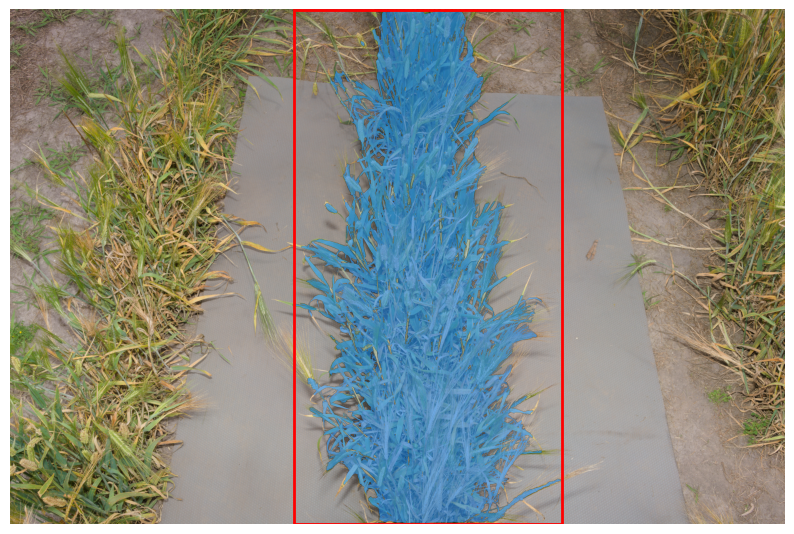

In [48]:
name = 'NCA03596'
image = cv2.imread(f'data/custom_data_fine_tuning/images/{name}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_height, image_width, _ = image.shape

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [49]:
model_type = 'vit_b'
checkpoint = 'data/models/sam/sam_checkpoints/sam_vit_b_01ec64.pth'
device = 'cuda'

In [50]:
from segment_anything import SamPredictor, sam_model_registry
checkpoint = "data/models/sam/sam_checkpoints/sam_vit_b_01ec64.pth"
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

We convert the input images into a format SAM's internal functions expect.

In [51]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'data/custom_data_fine_tuning/images/{k}.jpg')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]

  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size


In [52]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

## Run fine tuning

In [53]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 200
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  
  for k in keys:
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = np.array(bbox_coords[k])
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

EPOCH: 0
Mean loss: 10.934150425593058
EPOCH: 1
Mean loss: 13.690610520044963
EPOCH: 2
Mean loss: 13.733918984731039
EPOCH: 3
Mean loss: 13.81085131963094
EPOCH: 4
Mean loss: 13.813075510660807
EPOCH: 5
Mean loss: 13.813831742604574
EPOCH: 6
Mean loss: 13.81265590985616
EPOCH: 7
Mean loss: 13.812352879842122
EPOCH: 8
Mean loss: 13.812364546457927
EPOCH: 9
Mean loss: 13.812643829981486
EPOCH: 10
Mean loss: 13.812665557861328
EPOCH: 11
Mean loss: 13.813113896052043
EPOCH: 12
Mean loss: 13.814307069778442
EPOCH: 13
Mean loss: 13.814408763249714
EPOCH: 14
Mean loss: 13.814367485046386
EPOCH: 15
Mean loss: 13.814386336008708
EPOCH: 16
Mean loss: 13.81440183321635
EPOCH: 17
Mean loss: 13.814483674367269
EPOCH: 18
Mean loss: 13.814415772755941
EPOCH: 19
Mean loss: 13.814454698562622
EPOCH: 20
Mean loss: 13.81367212931315
EPOCH: 21
Mean loss: 13.810159063339233
EPOCH: 22
Mean loss: 13.814283736546834
EPOCH: 23
Mean loss: 13.814256048202514
EPOCH: 24
Mean loss: 13.814468415578206
EPOCH: 25
Mean

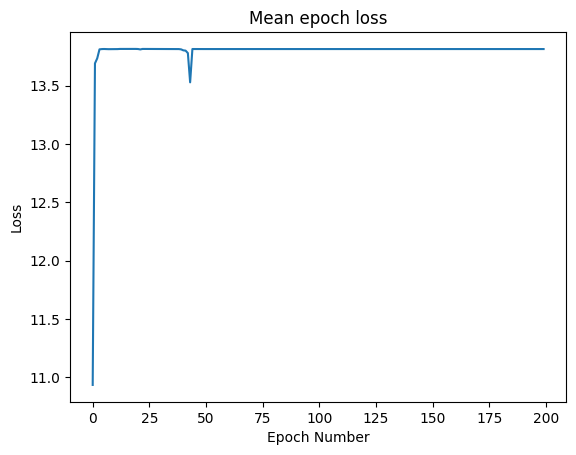

In [54]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [55]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [56]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [57]:
k = 'NCA03596'
image = cv2.imread(f'data/custom_data_fine_tuning/images/{k}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

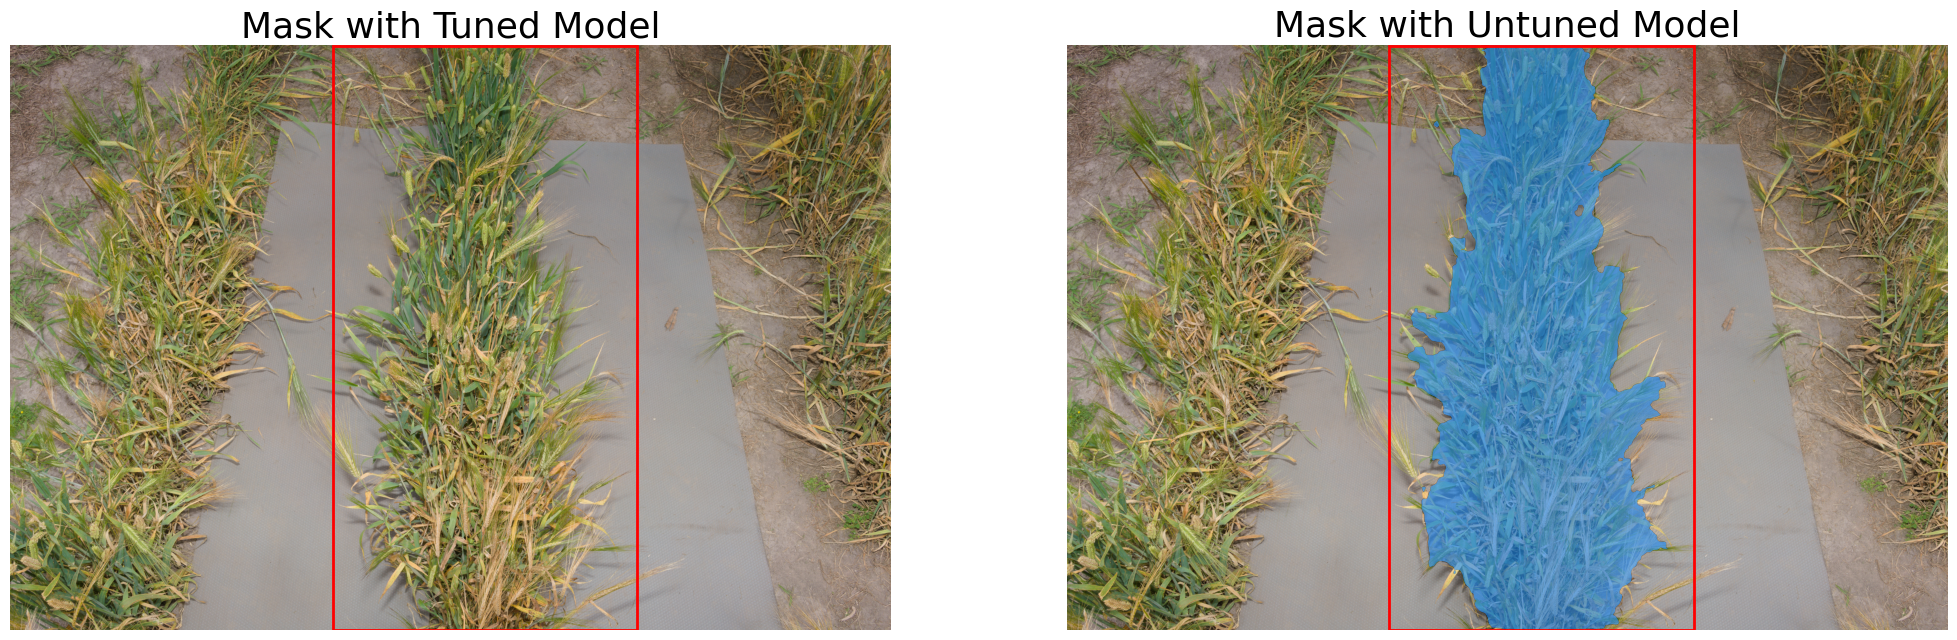

In [58]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()